## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import keras as k
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score
from itertools import chain
import pydicom

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import tensorflow as tf

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [18]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
27110,00007060_003.png,No Finding,3,7060,43,M,AP,2500,2048,0.171,0.171,NaN,/data/images_004/images/00007060_003.png
38995,00010202_000.png,No Finding,0,10202,52,M,PA,2500,2048,0.168,0.168,NaN,/data/images_005/images/00010202_000.png
86403,00021303_002.png,Atelectasis,2,21303,56,M,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00021303_002.png


In [19]:
all_xray_df.columns = ['image_index', 'finding_labels', 'follow_up', 'patient_id',
       'age', 'gender', 'view_position', 'width',  'height', 'pixel_x', 'pixel_y', 'unnamed', 'path']

In [20]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['finding_labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1:
        all_xray_df[c_label] = all_xray_df['finding_labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,image_index,finding_labels,follow_up,patient_id,age,gender,view_position,width,height,pixel_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
58038,00014361_002.png,No Finding,2,14361,37,M,PA,2670,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
46519,00011885_017.png,Cardiomegaly|Effusion|Infiltration,17,11885,53,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
24272,00006381_022.png,No Finding,22,6381,30,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df["pneumonia_class"] = all_xray_df.Pneumonia.apply(lambda x: "yes" if x>0 else "no")

## Create your training and testing data:

In [22]:
from sklearn.model_selection import train_test_split
from random import sample

def create_splits(df, target_name, test_size = 0.2, balance_train =  False, balance_test = False):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = train_test_split(df, 
                                            test_size = test_size, 
                                            stratify = df[target_name]) 

    if balance_train:  
        p_inds = train_df[train_df[target_name] == 'yes'].index.tolist()
        np_inds = train_df[train_df[target_name] == 'no'].index.tolist()

        np_sample = sample(np_inds,len(p_inds))
        train_df = train_df.loc[p_inds + np_sample]
        
    if balance_test:
        p_inds = valid_df[valid_df[target_name] == 'yes'].index.tolist()
        np_inds = valid_df[valid_df[target_name] == 'no'].index.tolist()

        # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
        np_sample = sample(np_inds, 4 * len(p_inds))
        valid_df = valid_df.loc[p_inds + np_sample]
    
    return train_df, valid_df

In [23]:
all_xray_df.pneumonia_class.value_counts()

no     110689
yes      1431
Name: pneumonia_class, dtype: int64

In [24]:
train, val_data = create_splits(all_xray_df, "pneumonia_class", 0.2, balance_train =  True, balance_test = True)

In [25]:
train.pneumonia_class.value_counts()

yes    1145
no     1145
Name: pneumonia_class, dtype: int64

In [26]:
val_data.pneumonia_class.value_counts()

no     1144
yes     286
Name: pneumonia_class, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [27]:
def my_image_augmentation(train = True):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    if train:
        idg = ImageDataGenerator(rescale = 1. / 255.0,
                                      horizontal_flip =  False, 
                                      vertical_flip = False , 
                                      height_shift_range = 0.1 , 
                                      width_shift_range = 0.1 , 
                                      rotation_range = 3, 
                                      shear_range = 0.9,
                                      zoom_range= 0.1
                                )
        
    else: 
        idg = ImageDataGenerator(rescale = 1. / 255.0)
    
    return idg

def make_train_gen(df, train_idg,  IMG_SIZE,  batch_size = 10):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = train_idg.flow_from_dataframe(dataframe = df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size
                                             )
    return train_gen


def make_val_gen(val_data, val_idg, IMG_SIZE, batch_size = 10):
    """
    
    
    """
    val_gen = val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size
                                            ) 
    
   
    return val_gen

In [28]:
train_dg = my_image_augmentation(train = True)
val_dg = my_image_augmentation(train = False)

train_gen = make_train_gen(train, train_dg, (224,224), batch_size = 16)
val_gen = make_val_gen(val_data, val_dg, (224,224), batch_size = 16)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [29]:
## May want to pull a single large batch of random validation data for testing after each epoch:
tX, tY = train_gen.next()

In [30]:
valX, valY = val_gen.next()

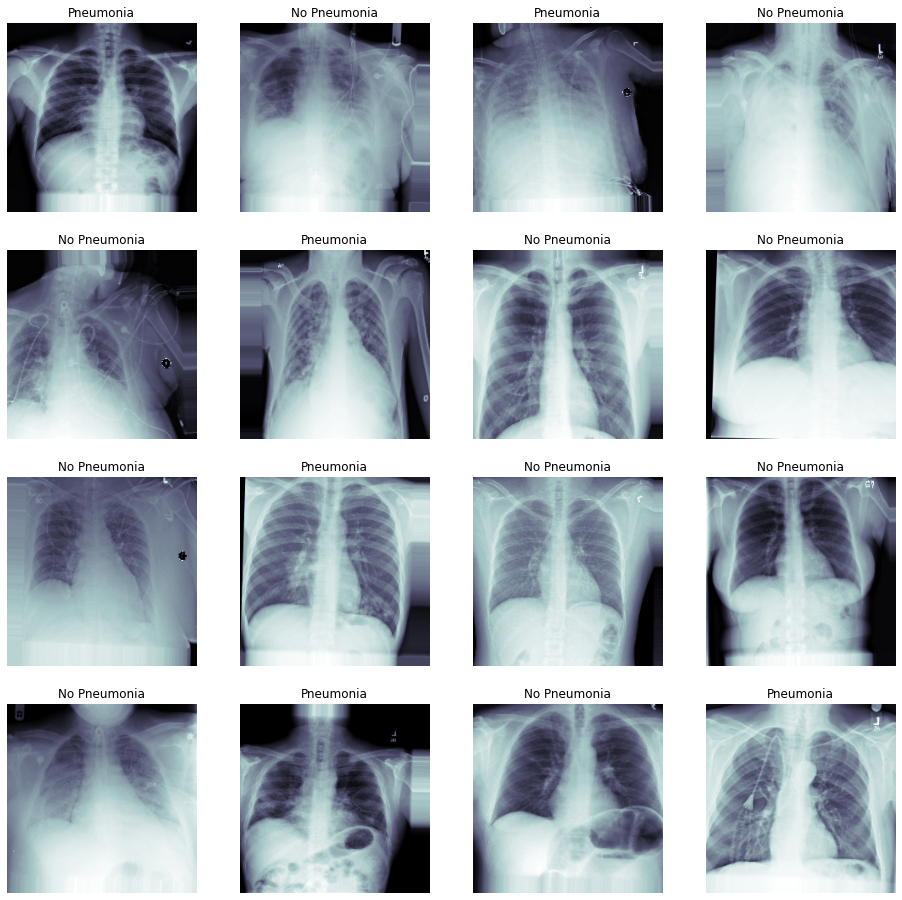

In [31]:
# t_x, t_y = next(gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(tX, tY, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [32]:
def load_pretrained_model(lay_of_interest = 'block5_pool'):
    
    model = VGG16(include_top = True, weights = 'imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model


In [8]:
vgg_model = load_pretrained_model()

553467904/553467096 [==============================] - 7s 0us/step


In [50]:
# vgg_model.summary()

In [5]:
def build_my_model(pretrained_model):
    
    for layer in pretrained_model.layers[0:17]:
        layer.trainable = False  
        
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    
    model.add(Dense(256,  activation = 'relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(1,  activation = 'sigmoid'))
    
    optimizer = Adam(lr = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']    
    
    
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)    
    
    
    return model

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor = "binary_accuracy", 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 0.8, 
                             save_weights_only = True)

early = EarlyStopping(monitor = "binary_accuracy", 
                      mode = 0.9, 
                      patience = 10)

callbacks_list = [checkpoint, early]

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:680: RuntimeWarning: ModelCheckpoint mode 0.8 is unknown, fallback to auto mode.
  RuntimeWarning)
/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:788: RuntimeWarning: EarlyStopping mode 0.9 is unknown, fallback to auto mode.
  RuntimeWarning)


### Start training! 

In [9]:
my_model = build_my_model(vgg_model)

In [ ]:
## train your model

# Todo

history = my_model.fit_generator(train_gen,  steps_per_epoch = 300,
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100
300/300 [==============================] - 131s 437ms/step - loss: 0.6900 - binary_accuracy: 0.5784 - val_loss: 0.6125 - val_binary_accuracy: 0.5625

Epoch 00001: binary_accuracy improved from -inf to 0.57837, saving model to xray_class_my_model.best.hdf5
Epoch 2/100
300/300 [==============================] - 124s 414ms/step - loss: 0.6469 - binary_accuracy: 0.6188 - val_loss: 0.6448 - val_binary_accuracy: 0.6875

Epoch 00002: binary_accuracy improved from 0.57837 to 0.61882, saving model to xray_class_my_model.best.hdf5
Epoch 3/100
300/300 [==============================] - 126s 418ms/step - loss: 0.6123 - binary_accuracy: 0.6658 - val_loss: 0.6664 - val_binary_accuracy: 0.6875

Epoch 00003: binary_accuracy improved from 0.61882 to 0.66576, saving model to xray_class_my_model.best.hdf5
Epoch 4/100
300/300 [==============================] - 125s 417ms/step - loss: 0.5827 - binary_accuracy: 0.6920 - val_loss: 0.8411 - val_binary_accuracy: 0.5000

Epoch 00004: binary_accuracy

In [12]:
my_model.load_weights('xray_class_my_model.best.hdf5')


# model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer=keras.optimizers.RMSprop())

# # Esto inicializa las variables utilizadas por los optimizadores,
# # así como cualquier variable métrica con estado
# model.train_on_batch(x_train[:1], y_train[:1])

# # Cargue el estado del modelo anterior.
# model.load_weights('path_to_my_weights')

In [13]:
my_model.layers[:8]

In [46]:
my_model.layers[:8]

In [15]:
from keras import models

layer_outputs = [layer.get_output_at(-1) for layer in my_model.layers[:10]]               
activation_model = models.Model(inputs = my_model.input, outputs=layer_outputs)

In [ ]:
history = my_model.history

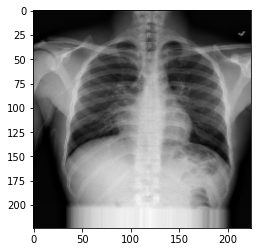

In [33]:
import matplotlib.pyplot as plt

plt.imshow(tX[0])
plt.show()

In [34]:
activations = activation_model.predict(tX)
# print(activations)

In [37]:
# activations

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [40]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
# ## so there is no need to make the model perfect.
# my_model.load_weights(weight_path)

pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

16/16 [==============================] - 10s 595ms/step


In [38]:
def plot_auc(t_y, p_y):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    
    ns_fpr, ns_tpr, _ = roc_curve(t_y, p_y)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.title("Training Accuracy on Dataset")
    plt.xlabel("False Positives")
    plt.ylabel("True Positives rate")
    plt.legend(loc = "lower left")
    

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall(t_y, p_y):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    
    precision_val, recall_val, _ = precision_recall_curve(t_y, p_y)
#     lr_f1, lr_auc = f1_score(t_y, p_y), auc(recall_val, precision_val)
    
#     print('Model 1 : f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    
    plt.plot(recall_val, precision_val, linestyle='--')
    plt.title("Training Accuracy on Dataset")
    plt.xlabel("False Positives")
    plt.ylabel("True Positives rate")
    plt.legend(loc = "lower left")    

    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return


def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    
    plt.figure()
    
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc = "lower left")

In [41]:
plot_precision_recall(valY, pred_Y)

NameError: name 'history' is not defined

No handles with labels found to put in legend.


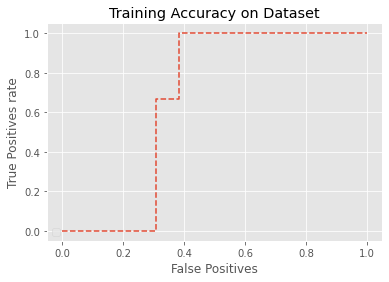

In [145]:
plot_auc(valY, pred_Y)

In [147]:
roc_auc_score(valY, pred_Y)

0.6666666666666667

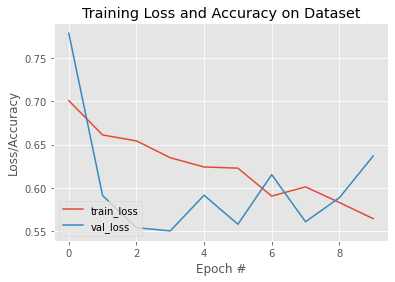

In [146]:
history = my_model.history
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)